In [1]:
from __future__ import print_function, division


from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
import pandas as pd
import datetime as dt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Load Data

In [2]:
#Customize Dataset Class
class LandmarkDataset(Dataset):
    def __init__(self, csv_path):
        
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]
                            )
        self.resize = transforms.Resize(224)
        self.crop = transforms.CenterCrop(224)
        self.data_info = pd.read_csv(csv_path, header=None)
        self.data_info.columns = ['id','url','label']
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 2])
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]+'.jpg'
        img = Image.open('95-891-hw3/images/'+single_image_name)
        img = self.resize(img)
        img = self.crop(img)
        img_as_tensor = self.to_tensor(img)
        img_as_tensor = self.normalize(img_as_tensor)
        single_image_label = self.label_arr[index]
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

if __name__ == "__main__":
    # Call dataset
    landmarks_train = LandmarkDataset('95-891-hw3/HW3_train.csv')

In [64]:
batch_size = 30
validation_split = .2
shuffle_dataset = True
dataset_size = len(landmarks_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed()
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(landmarks_train, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(landmarks_train, batch_size=batch_size, sampler=valid_sampler)
len_train = len(train_indices)
len_val = len(val_indices)

In [4]:
def imshow(axis, inp):
    #Denormalize and show the picture
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([30, 3, 224, 224]) torch.Size([30])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


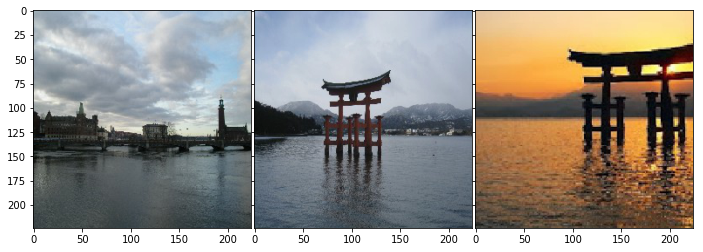

In [5]:
#Visualize 3 random images in the training dataset
img, label = next(iter(train_loader))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)    
for i in range(3):
    ax = grid[i]
    imshow(ax, img[i])

# Train a baseline model

In [5]:
use_gpu = torch.cuda.is_available()
volatile=True
model_ft = models.resnet18(pretrained=True) #ForResNet18
inputs, labels = next(iter(train_loader))
inputs, labels = Variable(inputs), Variable(labels)   
outputs = model_ft(inputs)
outputs.size()

torch.Size([30, 1000])

In [51]:
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 10)
if use_gpu:
    model_ft = model_ft.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dloaders = {'train':train_loader, 'valid':valid_loader}

In [68]:
def train_model(data, model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len_train, 
                     'valid': len_val}

    
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in data[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [69]:
start_time = time.time()
model = train_model(dloaders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

train Loss: 0.6577 Acc: 0.8261
valid Loss: 0.4612 Acc: 0.8606

train Loss: 0.4472 Acc: 0.8693
valid Loss: 0.3709 Acc: 0.8885

train Loss: 0.3884 Acc: 0.8838
valid Loss: 0.3430 Acc: 0.8919

train Loss: 0.3600 Acc: 0.8906
valid Loss: 0.3217 Acc: 0.9015

train Loss: 0.3384 Acc: 0.8948
valid Loss: 0.3138 Acc: 0.9004

Training complete in 14m 55s
Best val Acc: 0.901481


In [70]:
# Customize a Dataset class for test data
class LandmarkTest(Dataset):
    def __init__(self, csv_path):
        
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]
                            )
        self.crop = transforms.CenterCrop(224)
        self.data_info = pd.read_csv(csv_path, header=None)
        self.data_info.columns = ['id','url','label']
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 2])
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]+'.jpg'
        img = Image.open('95-891-hw3/images/'+single_image_name)
        img = self.crop(img)
        img_as_tensor = self.to_tensor(img)
        img_as_tensor = self.normalize(img_as_tensor)
        single_image_label = self.label_arr[index]
        return (img_as_tensor,single_image_label)

    def __len__(self):
        return self.data_len

if __name__ == "__main__":
    # Call dataset
    landmarks_test = LandmarkTest('95-891-hw3/HW3_test.csv')

In [71]:
def test(test_loader, model):
    op=[]
    for i, (input,label) in enumerate(test_loader):        
        input_var = torch.autograd.Variable(input.cuda(), volatile=True)
        output = model(input_var)
        if isinstance(output, tuple):
            output = output[len(output)-1]
        op.append(np.argmax(output.data.cpu().numpy(), axis=1)[0])

    return(op,label)

In [72]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    pred = []
    label = []
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)
        pred.append(preds)
        label.append(labels.data)
        del inputs, outputs,preds,labels
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_loader)
    avg_acc = acc_test / len(test_loader)
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return pred,label

**Evaluation of the baseline model**

In [73]:
test_loader = torch.utils.data.DataLoader(landmarks_test)
labels, preds = eval_model(model_ft, criterion)

Evaluating model
----------
Test batch 3300/3317
Evaluation completed in 0m 37s
Avg loss (test): 0.3556
Avg acc (test): 0.8830
----------


# Chosen Model

In [91]:
def visualize_model(model_ft, num_images=2):
    images_so_far = 0
    fig = plt.figure()
    class_names = {0:'St. Stephan\'s Cathedral, Austria',1:'Teide, Spain',2:'Tallinn, Estonia',3:'Brugge, Belgium',\
                   4:'Montreal, Canada',5:'Itsukushima Shrine, Japan',6:'Shanghai, China',7:'Brisbane, Australia',\
                  8:'Edinburgh, Scotland',9:'Stockholm, Sweden'}

    for i, data in enumerate(dloaders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(ax,inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [75]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 15)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [77]:
model_ft = train_model(dloaders, model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

train Loss: 0.3275 Acc: 0.9125
valid Loss: 0.0695 Acc: 0.9804

train Loss: 0.0500 Acc: 0.9877
valid Loss: 0.0545 Acc: 0.9844

train Loss: 0.0204 Acc: 0.9954
valid Loss: 0.0402 Acc: 0.9894

train Loss: 0.0117 Acc: 0.9980
valid Loss: 0.0379 Acc: 0.9891

train Loss: 0.0072 Acc: 0.9990
valid Loss: 0.0450 Acc: 0.9872

Training complete in 54m 6s
Best val Acc: 0.989444


## Visualize the prediction

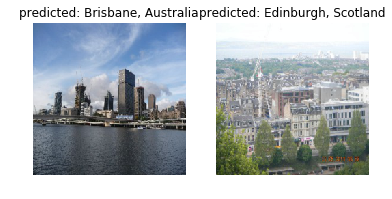

In [92]:
visualize_model(model_ft)
torch.save(model_ft.state_dict(), 'model_ft.pt')

In [80]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    pred = []
    label = []
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)
        pred.append(preds)
        label.append(labels.data)
        del inputs, outputs,preds,labels
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_loader)
    avg_acc = acc_test / len(test_loader)
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return pred,label

Next we call eval_model function to evaluate the performance of the model

In [81]:
labels, preds = eval_model(model_ft, criterion)

Evaluating model
----------
Test batch 3300/3317
Evaluation completed in 1m 11s
Avg loss (test): 0.0403
Avg acc (test): 0.9873
----------


In [94]:
from sklearn.metrics import confusion_matrix
a = confusion_matrix(labels,preds)

In [95]:
import numpy as np
a = np.array(a)
print(a)

[[339   0   0   0   1   0   1   0   0   0]
 [  0 391   0   0   0   0   0   0   0   0]
 [  1   0 355   0   0   0   0   0   0   1]
 [  0   0   3 334   0   0   0   0   1   0]
 [  0   1   0   2 338   2   0   0   5   0]
 [  0   0   0   0   0 334   0   0   0   0]
 [  0   0   0   0   2   1 305   0   2   1]
 [  0   0   1   1   2   0   1 316   0   2]
 [  1   0   1   1   1   0   1   0 322   0]
 [  0   0   1   1   1   0   1   0   2 241]]


In [96]:
result = []
for i in range(a.shape[0]):
    row = []
    for j in range(a.shape[1]):
        row.append(float("{:.4f}".format(a[i,j]/np.sum(a[i]))))
    result.append(row)

In [97]:
import pandas as pd
df = pd.DataFrame(result)

In [98]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.9941,0.0000,0.0000,0.0000,0.0029,0.0000,0.0029,0.0000,0.0000,0.0000
1,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0028,0.0000,0.9944,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028
3,0.0000,0.0000,0.0089,0.9882,0.0000,0.0000,0.0000,0.0000,0.0030,0.0000
4,0.0000,0.0029,0.0000,0.0057,0.9713,0.0057,0.0000,0.0000,0.0144,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0064,0.0032,0.9807,0.0000,0.0064,0.0032
7,0.0000,0.0000,0.0031,0.0031,0.0062,0.0000,0.0031,0.9783,0.0000,0.0062
8,0.0031,0.0000,0.0031,0.0031,0.0031,0.0000,0.0031,0.0000,0.9847,0.0000
9,0.0000,0.0000,0.0040,0.0040,0.0040,0.0000,0.0040,0.0000,0.0081,0.9757


In [99]:
precision = []
recall = []
for i in range(10):
    recall.append(a[i,i]/np.sum(a[i]))
    precision.append(a[i,i]/np.sum(a[:,i]))

In [100]:
for i in range(10):
    print("Category {}:\nPrecision:{:.4f}\nRecall:{:.4f}".format(i,precision[i],recall[i]))
    print()

Category 0:
Precision:0.9941
Recall:0.9941

Category 1:
Precision:0.9974
Recall:1.0000

Category 2:
Precision:0.9834
Recall:0.9944

Category 3:
Precision:0.9853
Recall:0.9882

Category 4:
Precision:0.9797
Recall:0.9713

Category 5:
Precision:0.9911
Recall:1.0000

Category 6:
Precision:0.9871
Recall:0.9807

Category 7:
Precision:1.0000
Recall:0.9783

Category 8:
Precision:0.9699
Recall:0.9847

Category 9:
Precision:0.9837
Recall:0.9757



Text(0.5,1,'Precision and Recall rate of categories')

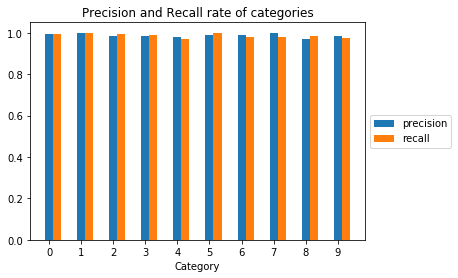

In [101]:
import matplotlib.pyplot as plt
width = 0.25 
plt.bar(range(10),precision,width,label= "precision")
plt.bar([i+width for i in range(10)],recall,width,label="recall")
plt.xticks(range(10))
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Category")
plt.title("Precision and Recall rate of categories")